In [1]:
using Turing
using FillArrays
using Flux
using Plots
using ReverseDiff

using LinearAlgebra
using Random
using CSV ,DataFrames
using StatsPlots
# Use reverse_diff due to the number of parameters in neural networks.
Turing.setadbackend(:reversediff)

:reversediff

In [2]:
begin
    data=CSV.read("w2021-1.csv",DataFrame,header=6)
    data0=CSV.read("w2022-1.csv",DataFrame,header=6)
    data1=CSV.read("w2020.csv",DataFrame,header=6)
    dataset2021=Array(transpose(Matrix(data[1:365,[5]])))
    dataset2022=Array(transpose(Matrix(data0[1:365,[5]])))
    dataset2020=Array(transpose(Matrix(data1[1:365,[4]])))
end

1×365 Matrix{Float64}:
 10.2  11.3  12.0  12.2  10.2  12.2  …  14.0  11.8  12.7  13.5  13.1  12.3

In [3]:
x0=Array(transpose(dataset2020[1:364]))
y0=Array(transpose(dataset2020[2:365]))
x1=Array(transpose(dataset2021[1:364]))
y1=Array(transpose(dataset2021[2:365]))
x2=Array(transpose(dataset2022[1:364]))
y2=Array(transpose(dataset2022[2:365]))

1×364 Matrix{Float64}:
 7.9  10.5  12.4  8.7  2.6  8.4  9.5  …  11.4  12.3  11.9  13.7  11.8  10.5

In [4]:
nn_initial = Chain(Dense(1, 3,tanh), Dense(3, 2,), Dense(2, 1,tanh))
parameters_initial, reconstruct = Flux.destructure(nn_initial)
nparameters=length(parameters_initial)

17

In [5]:
@model function bayes_nn(xs, ts, nparameters, reconstruct; alpha=0.09)
    # Create the weight and bias vector.
    parameters ~ MvNormal(Zeros(nparameters), I / alpha)
    nn = reconstruct(parameters)
    preds = nn(xs)
    for i in 1:length(ts)
        ts[i] ~ Normal(preds[i],1)
    end
end;

In [6]:
N = 1000
ch = sample(
    bayes_nn(x1, y1, length(parameters_initial), reconstruct), HMC(0.05, 1), N
);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:10


In [7]:
theta = MCMCChains.group(ch, :parameters).value;
nn_forward(x, theta) = reconstruct(theta)(x)
_, i = findmax(ch[:lp])
i = i.I[1]

384

In [8]:
nn_forward(x, theta) = reconstruct(theta)(x)

nn_forward (generic function with 1 method)

In [9]:


function nn_predict(x, theta, num)
    return mean([nn_forward(x, theta[i, :])[1] for i in 1:1:num])
end;

In [25]:
th=[nn_forward(x1, theta[i, :]) for i in 1:1:1000];

In [10]:
Z = [nn_predict([x1i], theta, 1000)[1] for x1i in x1 ]

1×364 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [14]:
z = [nn_predict([x1i], theta, 1000)[1] for x1i in y1 ]

1×364 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [19]:
log.(Z)

1×364 Matrix{Float64}:
 -2.54574e-13  -2.2482e-13  -7.32969e-13  …  -5.13589e-13  -5.9508e-14

In [17]:
Z[1:30]

30-element Vector{Float64}:
 0.9999999999997454
 0.9999999999997752
 0.999999999999267
 0.9999999999998249
 0.999999999999688
 0.9999999999969648
 0.9999999999998954
 0.9999999999963191
 0.999999999999267
 0.9999999999990415
 0.9999999999963191
 0.9999999999946413
 0.9999999999998874
 ⋮
 0.9999999999996171
 0.9999999999996171
 0.9999999999997657
 0.9999999999999625
 0.9999999999997123
 0.9999999999963191
 0.9999999999999117
 0.9999999999998095
 0.9999999999999646
 0.9999999999988382
 0.9999999999997752
 0.9999999999995819

In [12]:
sum(Z.*x1)

7797.0999999994765

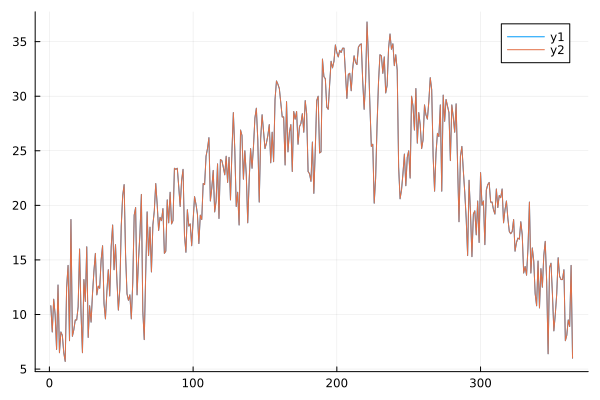

In [15]:
plot((z.*y1)')
plot!(y1')

In [60]:
nn_initial = Chain(Dense(1, 3), Dense(3, 2,), Dense(2, 1))
parameters_initial, reconstruct = Flux.destructure(nn_initial)
nparameters=length(parameters_initial)

N = 1000
ch = sample(
    bayes_nn(x1, y1, length(parameters_initial), reconstruct), HMC(0.05, 1), N
);

theta = MCMCChains.group(ch, :parameters).value;
nn_forward(x, theta) = reconstruct(theta)(x)

#th=[nn_forward(x1, theta[i, :]) for i in 1:1:1000]


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:09


nn_forward (generic function with 1 method)

In [61]:
Z = [nn_predict([x1i], theta, 1000)[1] for x1i in x1 ]

1×364 Matrix{Float64}:
 173.393  178.605  136.916  189.027  …  131.704  156.023  145.601  242.875

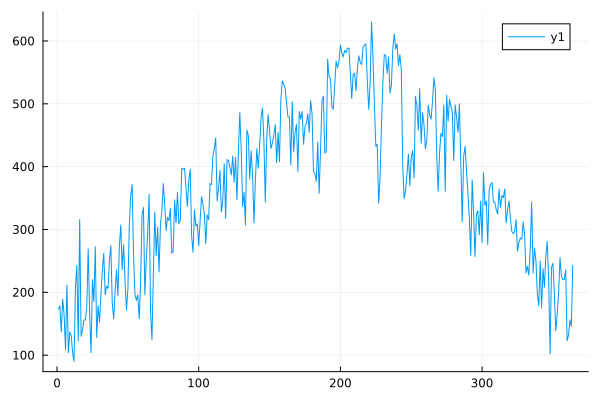

In [62]:
plot(Z')

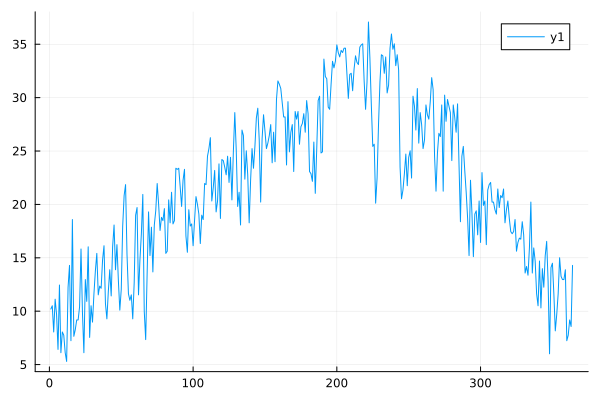

In [63]:
plot(((Z./norm(Z)).*norm(x1))')

In [64]:
Z1 = [nn_predict([x1i], theta, 1000)[1] for x1i in x2 ]

1×364 Matrix{Float64}:
 126.493  128.23  173.393  206.397  …  204.66  197.712  228.979  195.975

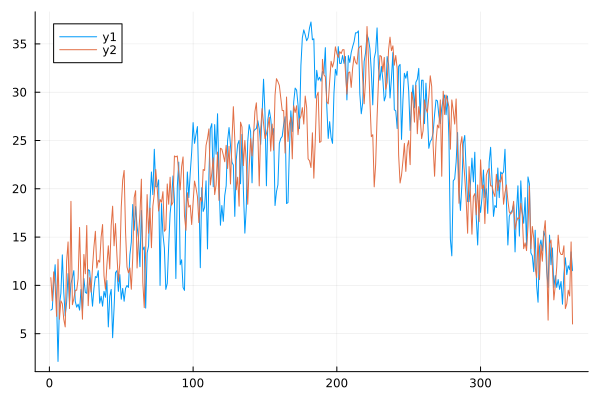

In [65]:
plot(((Z1./norm(Z1)).*norm(x2))')
plot!(y1')

In [68]:
using Turing
using AbstractGPs
using FillArrays
using LaTeXStrings
using Plots
using RDatasets
using ReverseDiff
using StatsBase

using LinearAlgebra
using Random

Random.seed!(1789);

In [69]:
linear_kernel(α) = LinearKernel() ∘ ARDTransform(α)
sekernel(α, σ) = σ * SqExponentialKernel() ∘ ARDTransform(α);

In [74]:
gp=GP(linear_kernel(rand(10)))

GP{AbstractGPs.ZeroMean{Float64}, TransformedKernel{LinearKernel{Float64}, ARDTransform{Vector{Float64}}}}(AbstractGPs.ZeroMean{Float64}(), Linear Kernel (c = 0.0)
	- ARD Transform (dims: 10))

In [78]:
@model function gdemo(x, y)
    s² ~ InverseGamma(2, 3)
    m ~ Normal(0, sqrt(s²))
    x ~ Normal(m, sqrt(s²))
    return y ~ Normal(m, sqrt(s²))
end

gdemo (generic function with 2 methods)

In [80]:
chn = sample(gdemo(1.5, 2), HMC(0.1, 5), 1000)

Chains MCMC chain (1000×11×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 3.27 seconds
Compute duration  = 3.27 seconds
parameters        = s², m
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          s²    1.8246    1.3715     0.0434    0.1067   129.5536    1.0108     ⋯
           m    1.1632    0.6897     0.0218    0.0634   118.3943    1.0105     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          s²    0.5316    0.9563    1.4482    2.2034    5.2000
        

In [95]:
nn_initial = Chain(Dense(1, 3, tanh), Dense(3, 2, tanh), Dense(2, 1, σ))

# Extract weights and a helper function to reconstruct NN from weights
parameters_initial, reconstruct = Flux.destructure(nn_initial)

length(parameters_initial) 

17

In [96]:
@model function bayes_nn(xs, ts, nparameters, reconstruct; alpha=0.09)
    # Create the weight and bias vector.
    parameters ~ MvNormal(Zeros(nparameters), I / alpha)

    # Construct NN from parameters
    nn = reconstruct(parameters)
    # Forward NN to make predictions
    preds = nn(xs)

    # Observe each prediction.
    for i in 1:length(ts)
        ts[i] ~ Bernoulli(preds[i])
    end
    
    return (; parameters ,preds ,ts)
end

bayes_nn (generic function with 2 methods)

In [97]:
m=bayes_nn(x1,y1,17,reconstruct)

DynamicPPL.Model{typeof(bayes_nn), (:xs, :ts, :nparameters, :reconstruct, :alpha), (:alpha,), (), Tuple{Matrix{Float64}, Matrix{Float64}, Int64, Optimisers.Restructure{Chain{Tuple{Dense{typeof(tanh), Matrix{Float32}, Vector{Float32}}, Dense{typeof(tanh), Matrix{Float32}, Vector{Float32}}, Dense{typeof(σ), Matrix{Float32}, Vector{Float32}}}}, NamedTuple{(:layers,), Tuple{Tuple{NamedTuple{(:weight, :bias, :σ), Tuple{Int64, Int64, Tuple{}}}, NamedTuple{(:weight, :bias, :σ), Tuple{Int64, Int64, Tuple{}}}, NamedTuple{(:weight, :bias, :σ), Tuple{Int64, Int64, Tuple{}}}}}}}, Float64}, Tuple{Float64}, DynamicPPL.DefaultContext}(bayes_nn, (xs = [10.5 10.8 … 8.9 14.5], ts = [10.8 8.4 … 14.5 6.0], nparameters = 17, reconstruct = Restructure(Chain, ..., 17), alpha = 0.09), (alpha = 0.09,), DynamicPPL.DefaultContext())

In [98]:
m()

(parameters = [0.5278962894271609, -2.701947701983929, 1.845279014429003, -1.3765377738103077, -0.2698672813165606, -0.47707397224029136, 7.202849790736301, 1.6209862264305697, 4.469810073240058, -0.9863432024238585, -4.760956039490448, 0.6422676636199287, 4.030290780322446, 1.0055551736282298, -3.640311170683377, -0.01509780926775786, -0.28427950819758085], preds = [0.021701122972904396 0.021695983656119803 … 0.02178610840765976 0.021682516328475374], ts = [10.8 8.4 … 14.5 6.0])

#1

In [109]:
using Distances

In [83]:
mean(chn[:m])

1.163192817718507

In [110]:
pairwise(Distances.Euclidean(), x1, dims=1)

1×1 Matrix{Float64}:
 0.0

In [101]:
size(x1)

(1, 364)

In [111]:
data = dataset("datasets", "iris")
species = data[!, "Species"]
index = shuffle(1:150)
# we extract the four measured quantities,
# so the dimension of the data is only d=4 for this toy example
dat = Matrix(data[index, 1:4])
labels = data[index, "Species"]

# non-linearize data to demonstrate ability of GPs to deal with non-linearity
dat[:, 1] = 0.5 * dat[:, 1] .^ 2 + 0.1 * dat[:, 1] .^ 3
dat[:, 2] = dat[:, 2] .^ 3 + 0.2 * dat[:, 2] .^ 4
dat[:, 3] = 0.1 * exp.(dat[:, 3]) - 0.2 * dat[:, 3] .^ 2
dat[:, 4] = 0.5 * log.(dat[:, 4]) .^ 2 + 0.01 * dat[:, 3] .^ 5

# normalize data
dt = fit(ZScoreTransform, dat; dims=1);
StatsBase.transform!(dt, dat);

In [118]:
rMvLogNormal(MvNormal(Zeros(10), I))

MvLogNormal{Float64, PDMats.ScalMat{Float64}, Zeros{Float64, 1, Tuple{Base.OneTo{Int64}}}}(
dim: 10
μ: Zeros(10)
Σ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)


In [121]:
rand(filldist(Normal(), 10))

10-element Vector{Float64}:
 -1.1500496025552138
 -0.08198082609780913
 -0.5712724464404112
  1.0925736662326397
 -0.9850345229461466
  0.3562213079950824
  1.6857745401800037
  0.1896279314590318
 -0.013434350516550907
 -0.49655854852212605

In [131]:
[rand(Normal())]

1-element Vector{Float64}:
 0.7410316014849513

In [129]:
vec(rand(Normal()))

LoadError: MethodError: no method matching vec(::Float64)
[0mClosest candidates are:
[0m  vec([91m::Transpose{<:Number, <:AbstractVector}[39m) at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/stdlib/v1.7/LinearAlgebra/src/adjtrans.jl:215
[0m  vec([91m::Adjoint{<:Real, <:AbstractVector}[39m) at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/stdlib/v1.7/LinearAlgebra/src/adjtrans.jl:216
[0m  vec([91m::SparseArrays.AbstractSparseVector[39m) at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/stdlib/v1.7/SparseArrays/src/sparsevector.jl:964
[0m  ...

In [132]:
gp=GP(linear_kernel([rand(Normal())]))

GP{AbstractGPs.ZeroMean{Float64}, TransformedKernel{LinearKernel{Float64}, ARDTransform{Vector{Float64}}}}(AbstractGPs.ZeroMean{Float64}(), Linear Kernel (c = 0.0)
	- ARD Transform (dims: 1))

In [143]:
kc=cov(gp(x1,0.01))

364×364 Matrix{Float64}:
 159.873   164.431   127.891   173.566   …  144.638   135.503   220.764
 164.431   169.139   131.545   178.525      148.771   139.375   227.071
 127.891   131.545   102.323   138.853      115.711   108.403   176.611
 173.566   178.525   138.853   188.453      157.036   147.118   239.686
 152.251   156.601   121.801   165.301      137.751   129.051   210.251
 103.531   106.489    82.8245  112.405   …   93.6705   87.7545  142.971
 193.359   198.883   154.687   209.932      174.944   163.894   267.019
  98.9631  101.791    79.1705  107.446       89.538    83.883   136.663
 127.891   131.545   102.313   138.853      115.711   108.403   176.611
 123.323   126.847    98.6586  133.894      111.578   104.531   170.303
  98.9631  101.791    79.1705  107.446   …   89.538    83.883   136.663
  86.783    89.2625   69.4264   94.2215      78.518    73.5589  119.843
 190.314   195.751   152.251   206.626      172.189   161.313   262.814
   ⋮                                   

In [147]:
length(x1)

364

In [157]:
v = randn(364,1);

In [158]:
v

364×1 Matrix{Float64}:
 -0.1965743451113532
  0.10649548113994035
  0.6881765769747902
 -1.1966131787667202
 -0.43385481798408965
 -0.6245099994094233
 -0.8642456966845098
  0.873950767765186
 -0.41143852685119564
 -1.133166535847295
 -1.4241859151773613
  1.4755976130751092
  1.2460058408541237
  ⋮
 -0.4286227891719643
 -1.2812728144503895
 -0.17081794786799054
 -1.0154637577605723
  0.17284088051930105
  1.3529208988571098
 -0.2863125631917593
  0.5468521397247869
 -0.5166068986810892
  0.37502945218439704
  0.31918232191621215
 -0.1708710829083363

In [159]:
cholesky(kc+ 1e-6 * I).U

364×364 UpperTriangular{Float64, Matrix{Float64}}:
 12.6441  13.0046    10.1147     13.727      …  10.7167      17.4598
   ⋅       0.143461   0.0573598   0.0778454      0.0607741    0.0990139
   ⋅        ⋅         0.114504    0.0368621      0.0287783    0.0468859
   ⋅        ⋅          ⋅          0.119877       0.0284563    0.0463614
   ⋅        ⋅          ⋅           ⋅             0.018746     0.0305413
   ⋅        ⋅          ⋅           ⋅         …   0.0110032    0.0179265
   ⋅        ⋅          ⋅           ⋅             0.0174085    0.0283622
   ⋅        ⋅          ⋅           ⋅             0.00765476   0.0124712
   ⋅        ⋅          ⋅           ⋅             0.00921064   0.0150061
   ⋅        ⋅          ⋅           ⋅             0.00819291   0.013348
   ⋅        ⋅          ⋅           ⋅         …   0.00619242   0.0100888
   ⋅        ⋅          ⋅           ⋅             0.00522087   0.00850591
   ⋅        ⋅          ⋅           ⋅             0.0104626    0.0170458
  ⋮             

In [153]:
cholesky(kc+ 1e-6 * I).L

364×364 LowerTriangular{Float64, Matrix{Float64}}:
 12.6441    ⋅          ⋅         …   ⋅           ⋅          ⋅ 
 13.0046   0.143461    ⋅             ⋅           ⋅          ⋅ 
 10.1147   0.0573598  0.114504       ⋅           ⋅          ⋅ 
 13.727    0.0778454  0.0368621      ⋅           ⋅          ⋅ 
 12.0413   0.0682855  0.0323351      ⋅           ⋅          ⋅ 
  8.18805  0.0464341  0.0219879  …   ⋅           ⋅          ⋅ 
 15.2924   0.0867225  0.0410656      ⋅           ⋅          ⋅ 
  7.82681  0.0443856  0.0210178      ⋅           ⋅          ⋅ 
 10.1147   0.0573598  0.0271615      ⋅           ⋅          ⋅ 
  9.75341  0.0553112  0.0261915      ⋅           ⋅          ⋅ 
  7.82681  0.0443856  0.0210178  …   ⋅           ⋅          ⋅ 
  6.86351  0.0389227  0.018431       ⋅           ⋅          ⋅ 
 15.0516   0.0853568  0.0404189      ⋅           ⋅          ⋅ 
  ⋮                              ⋱                         
 12.0413   0.0682855  0.0323351      ⋅           ⋅          ⋅ 
 14.329

In [161]:
cholesky(kc)

Cholesky{Float64, Matrix{Float64}}
U factor:
364×364 UpperTriangular{Float64, Matrix{Float64}}:
 12.6441  13.0046    10.1147     13.727      …  10.7167      17.4598
   ⋅       0.143454   0.0573569   0.0778415      0.060771     0.099009
   ⋅        ⋅         0.114498    0.0368602      0.0287768    0.0468836
   ⋅        ⋅          ⋅          0.119871       0.0284549    0.0463591
   ⋅        ⋅          ⋅           ⋅             0.0187451    0.0305397
   ⋅        ⋅          ⋅           ⋅         …   0.0110026    0.0179256
   ⋅        ⋅          ⋅           ⋅             0.0174076    0.0283607
   ⋅        ⋅          ⋅           ⋅             0.00765438   0.0124706
   ⋅        ⋅          ⋅           ⋅             0.00921018   0.0150053
   ⋅        ⋅          ⋅           ⋅             0.00819251   0.0133473
   ⋅        ⋅          ⋅           ⋅         …   0.00619211   0.0100883
   ⋅        ⋅          ⋅           ⋅             0.00522061   0.00850548
   ⋅        ⋅          ⋅           ⋅       

In [201]:
cholesky(hh)

LoadError: PosDefException: matrix is not positive definite; Cholesky factorization failed.

In [160]:
cholesky(kc+ 1e-6 * I).L*v

364×1 Matrix{Float64}:
 -2.4855069597123367
 -2.5410835971826202
 -1.9033738698015548
 -2.808170101983078
 -2.42393351136169
 -1.6868494118256883
 -3.1364243197184343
 -1.4762989319744657
 -2.060639644429764
 -2.066681740651188
 -1.7165202737406946
 -1.2330972963857731
 -2.8883105948353722
  ⋮
 -2.4941263969794156
 -3.045198156767963
 -3.7431541049737613
 -3.4109505044094184
 -3.2186124948305315
 -3.100527147059429
 -3.4850308346682866
 -1.808334926579773
 -2.0372535022845484
 -2.291275429322564
 -2.1497642925719966
 -3.5715157339297354

1×364 Matrix{Float64}:
 10.5  10.8  8.4  11.4  10.0  6.8  12.7  …  14.1  7.6  8.1  9.5  8.9  14.5

In [120]:
rand(filldist(Normal(), 10, 10))

10×10 Matrix{Float64}:
  1.1822      0.18979    -1.90042     …   0.950752   -0.202002   -0.131823
  3.11895     1.81796    -0.915278        0.736482    0.366877   -0.356599
 -1.37302    -0.065857   -0.00289534     -0.0965763   1.08857    -1.71868
  1.6183      0.74662    -0.58443        -0.638233   -0.0738499   0.0992435
 -0.898521    0.139053   -1.40116        -0.165084   -0.0070853  -0.917709
 -0.0282625   0.479872    0.518895    …  -0.312215    1.04054     1.69031
  2.18728     0.450342    0.0790569      -0.463349   -0.233127    0.00281834
 -0.968367    0.0781714   1.46565        -0.927982   -0.252073   -0.0460959
 -0.637824   -0.653919   -1.3079         -1.27763    -0.354896   -0.0887298
 -0.0291973   0.839061    0.598276       -0.99966     0.412051    1.44646

In [117]:
@assert 1 <= 1

In [217]:
MvNormal(Zeros(4), I)

ZeroMeanIsoNormal(
dim: 4
μ: Zeros(4)
Σ: [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0]
)


In [221]:
I(4)

4×4 Diagonal{Bool, Vector{Bool}}:
 1  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅
 ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  1

In [151]:
pp=rand(MvNormal(Zeros(17), I / 0.09),1)

17×1 Matrix{Float64}:
 -3.8891634300660005
 -5.441494857087991
 -5.785339363705538
  1.5831523291675471
 -1.810440603548316
 -3.0076798570581853
  2.2482290798772437
  2.1960800119014197
  5.541604876112153
 -4.404490883672793
  5.56987232099725
 -0.13487874373708514
 -1.0586023861551883
  1.90852275002382
 -4.78456174973588
  3.123584045458576
  0.5161065989738574

In [215]:
y1'*y1

364×364 Matrix{Float64}:
 116.64   90.72  123.12  108.0   73.44  …  102.6    96.12  156.6   64.8
  90.72   70.56   95.76   84.0   57.12      79.8    74.76  121.8   50.4
 123.12   95.76  129.96  114.0   77.52     108.3   101.46  165.3   68.4
 108.0    84.0   114.0   100.0   68.0       95.0    89.0   145.0   60.0
  73.44   57.12   77.52   68.0   46.24      64.6    60.52   98.6   40.8
 137.16  106.68  144.78  127.0   86.36  …  120.65  113.03  184.15  76.2
  70.2    54.6    74.1    65.0   44.2       61.75   57.85   94.25  39.0
  90.72   70.56   95.76   84.0   57.12      79.8    74.76  121.8   50.4
  87.48   68.04   92.34   81.0   55.08      76.95   72.09  117.45  48.6
  70.2    54.6    74.1    65.0   44.2       61.75   57.85   94.25  39.0
  61.56   47.88   64.98   57.0   38.76  …   54.15   50.73   82.65  34.2
 135.0   105.0   142.5   125.0   85.0      118.75  111.25  181.25  75.0
 156.6   121.8   165.3   145.0   98.6      137.75  129.05  210.25  87.0
   ⋮                                   

In [214]:
cov(gp(y1),)

364×364 Matrix{Float64}:
 169.129   131.545   178.525   156.601   …  139.375   227.071   93.9605
 131.545   102.313   138.853   121.801      108.403   176.611   73.0804
 178.525   138.853   188.443   165.301      147.118   239.686   99.1806
 156.601   121.801   165.301   145.001      129.051   210.251   87.0005
 106.489    82.8245  112.405    98.6006      87.7545  142.971   59.1603
 198.883   154.687   209.932   184.151   …  163.894   267.019  110.491
 101.791    79.1705  107.446    94.2505      83.883   136.663   56.5503
 131.545   102.313   138.853   121.801      108.403   176.611   73.0804
 126.847    98.6586  133.894   117.451      104.531   170.303   70.4704
 101.791    79.1705  107.446    94.2505      83.883   136.663   56.5503
  89.2625   69.4264   94.2215   82.6505  …   73.5589  119.843   49.5903
 195.751   152.251   206.626   181.251      161.313   262.814  108.751
 227.071   176.611   239.686   210.251      187.124   304.864  126.151
   ⋮                                     ⋱

In [203]:
argmax(hh)

CartesianIndex(2, 1)

In [205]:
hh[2,1]

0.0

In [183]:
pp=rand(Normal(0, 1/ 0.09),17)

17-element Vector{Float64}:
 -17.968101170345182
   0.555450858810844
  -0.3281202997105102
   7.254042287716854
  -9.693673824293825
  18.414326816168305
 -27.62112625048879
   4.261940690707142
  16.11484113696402
  -7.936187441583374
 -14.521726882687307
  26.940509775837793
   7.130028602309343
  22.478242593538894
  -3.989214965760852
   9.193736482950923
  -5.826655943326818

In [207]:
lo=(pp->-(al/2)*pp'pp-(bl/2)*sum((reconstruct(pp)(x1).-y1).^2))

#40 (generic function with 1 method)

3539.8755144899237

In [193]:
y1

1×364 Matrix{Float64}:
 10.8  8.4  11.4  10.0  6.8  12.7  …  14.1  7.6  8.1  9.5  8.9  14.5  6.0

In [195]:
(reconstruct(pp)(x1).-y1).^2

1×364 Matrix{Float64}:
 96.04  54.76  108.16  81.0  33.64  …  50.41  72.25  62.41  182.25  25.0

In [167]:
al=0.3
bl=0.25

0.25

In [197]:
lo(pp)

-21981.71132717348

In [198]:
using Zygote

In [222]:
hh=hessian(lo,pp);

In [224]:
abs.(inv(hh));

In [229]:
rand(364,1)

364×1 Matrix{Float64}:
 0.20730018290721342
 0.9665057665661038
 0.8515308867427138
 0.4088359615087731
 0.8285553027365516
 0.4372075016257869
 0.5590347116550598
 0.7381221737438975
 0.9615200383645113
 0.2348622461031108
 0.43016822395970233
 0.3274887565140209
 0.68756413265397
 ⋮
 0.6014505805678748
 0.8749773741231522
 0.24194820526547933
 0.3091603435304824
 0.5733263833503671
 0.40029857007472336
 0.46537101615381316
 0.15898692344036247
 0.5822654343168098
 0.05775672206841076
 0.3404699740441067
 0.8946739075938906

In [235]:
wm=cholesky(abs.(inv(hh))).L*rand(17,1)

17×1 Matrix{Float64}:
 1.0764833350061151
 1.4276962700274436
 1.394097187220281
 0.5865973037329081
 1.0501740860520516
 1.4344550885635812
 1.5242809046796142
 1.4470371776164352
 0.4932676866753214
 1.161713857351477
 0.14696617458432215
 1.1307995744099524
 1.7292164688262186
 1.0275343822996403
 1.4930081854447628
 0.23008834017393284
 0.6628288380532973

In [240]:
cc=abs.(inv(hh));

In [245]:
vec(wm)

17-element Vector{Float64}:
 1.0764833350061151
 1.4276962700274436
 1.394097187220281
 0.5865973037329081
 1.0501740860520516
 1.4344550885635812
 1.5242809046796142
 1.4470371776164352
 0.4932676866753214
 1.161713857351477
 0.14696617458432215
 1.1307995744099524
 1.7292164688262186
 1.0275343822996403
 1.4930081854447628
 0.23008834017393284
 0.6628288380532973

In [247]:
dm=MvNormal(vec(wm),cc)

FullNormal(
dim: 17
μ: [1.0764833350061151, 1.4276962700274436, 1.394097187220281, 0.5865973037329081, 1.0501740860520516, 1.4344550885635812, 1.5242809046796142, 1.4470371776164352, 0.4932676866753214, 1.161713857351477, 0.14696617458432215, 1.1307995744099524, 1.7292164688262186, 1.0275343822996403, 1.4930081854447628, 0.23008834017393284, 0.6628288380532973]
Σ: [3.3333333333333335 0.0 … 0.0 0.0; 0.0 3.3333333333333335 … 0.0 0.0; … ; 0.0 0.0 … 3.3333333333333335 0.0; 0.0 0.0 … 0.0 3.3333333333333335]
)


In [114]:
Array(x1')

364×1 Matrix{Float64}:
 10.5
 10.8
  8.4
 11.4
 10.0
  6.8
 12.7
  6.5
  8.4
  8.1
  6.5
  5.7
 12.5
  ⋮
 10.0
 11.9
 15.2
 13.5
 13.2
 13.2
 14.1
  7.6
  8.1
  9.5
  8.9
 14.5

In [180]:
Float32.(pp)

17×1 Matrix{Float32}:
 -3.8891635
 -5.441495
 -5.7853394
  1.5831523
 -1.8104407
 -3.00768
  2.248229
  2.19608
  5.541605
 -4.404491
  5.5698724
 -0.13487874
 -1.0586023
  1.9085227
 -4.7845616
  3.123584
  0.5161066

In [248]:
reconstruct(pp)(x1)

1×364 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [250]:
wm

17×1 Matrix{Float64}:
 1.0764833350061151
 1.4276962700274436
 1.394097187220281
 0.5865973037329081
 1.0501740860520516
 1.4344550885635812
 1.5242809046796142
 1.4470371776164352
 0.4932676866753214
 1.161713857351477
 0.14696617458432215
 1.1307995744099524
 1.7292164688262186
 1.0275343822996403
 1.4930081854447628
 0.23008834017393284
 0.6628288380532973

In [251]:
reconstruct(vec(wm))(x1)

1×364 Matrix{Float64}:
 0.999999  0.999999  0.999999  0.999999  …  0.999999  0.999999  0.999999

In [257]:
vec(reconstruct(pp)(x1))

364-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [258]:
MvNormal(vec(reconstruct(pp)(x1)),I/0.09)

IsoNormal(
dim: 364
μ: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Σ: [11.11111111111111 0.0 … 0.0 0.0; 0.0 11.11111111111111 … 0.0 0.0; … ; 0.0 0.0 … 11.11111111111111 0.0; 0.0 0.0 … 0.0 11.11111111111111]
)


In [ ]:
@model function bayes_nn(xs, ts, nparameters, reconstruct; alpha=0.09)
    # Create the weight and bias vector.
    parameters ~ MvNormal(Zeros(nparameters), I / alpha)
    nn = reconstruct(parameters)
    preds = nn(xs)
    for i in 1:length(ts)
        ts[i] ~ Normal(preds[i],1)
    end
end;

In [274]:
nn_initial = Chain(Dense(1, 3,tanh), Dense(3, 2,), Dense(2, 1))
parameters_initial, reconstruct = Flux.destructure(nn_initial)
nparameters=length(parameters_initial)

17

In [260]:
w=vec(rand(MvNormal(zeros(17), I / 0.09),1))

17-element Vector{Float64}:
 -0.8157051182056303
  0.8255803908504304
  0.828776290115462
  1.122752896950466
 -2.0540868773864513
  0.7596107109148863
 -1.9025349459705085
  3.1638891592540017
  3.83591262450103
  3.022942741613782
  3.4971822529537273
 -1.809095419083939
 -0.16712936527082944
  2.5165157681261277
 -1.7831451200054265
  2.9101343709474476
  2.201047515898164

In [264]:
pw=pdf.(Normal(0, 1 / 0.09),w)

17-element Vector{Float64}:
 0.03580818036157667
 0.035805829883247826
 0.03580506318168429
 0.035721966659582625
 0.03529647433942867
 0.03582099782809958
 0.03538229657442592
 0.034478289943064504
 0.03382765026329179
 0.034600270387761665
 0.03416967272032924
 0.0354320292048921
 0.03590074371645376
 0.03499562620468447
 0.03544540873342032
 0.03469418746799674
 0.035207195028963294

In [275]:
nn=reconstruct(w)

Chain(
  Dense(1 => 3, tanh),                  # 6 parameters
  Dense(3 => 2),                        # 8 parameters
  Dense(2 => 1),                        # 3 parameters
)                   # Total: 6 arrays, 17 parameters, 452 bytes.

In [278]:
nn(x1)

1×364 Matrix{Float64}:
 -12.3209  -12.3209  -12.3208  -12.3209  …  -12.3209  -12.3209  -12.3209

In [283]:
argmax(cov(nn(x1)))

CartesianIndex(1, 1)

In [289]:
argmax(cov(nn(x1)'nn(x1)))

CartesianIndex(89, 53)

In [294]:
Float64(cov(nn(x1)'nn(x1))[89,53])

4.551256960432474e-6

In [285]:
(cov(nn(x1))[1,1])

NaN

In [301]:
argmax(cov(nn(x1)'nn(x1)))

CartesianIndex(89, 53)

In [303]:
(nn(x1).-y1).^2

1×364 Matrix{Float64}:
 534.575  429.355  562.678  498.222  …  476.148  450.326  719.359  335.655

In [307]:
a=0.09

0.09

In [313]:
b=(mean(nn(x1).^2)-mean(nn(x1))^2)

2.989872882608324e-8

In [340]:
pdw=1
for i in length(x1)
    pdw *=pdf(Normal(nn(x1)[i],inv(b)),y1[i])
end

In [ ]:
pw

In [341]:
pdw*

1.192786705897991e-8

In [330]:
rand(Normal(nn(x1)[1],b),10)

10-element Vector{Float64}:
 -12.320887783220476
 -12.320887758784867
 -12.32088778129784
 -12.32088775065701
 -12.320887821007437
 -12.320887830234161
 -12.320887705780688
 -12.32088776170867
 -12.320887716618465
 -12.320887731290032

In [343]:
pwu=pdw*pw

17-element Vector{Float64}:
 4.2711521497686175e-10
 4.2708717878383023e-10
 4.270780336695065e-10
 4.260868694008142e-10
 4.210116535714009e-10
 4.272681000135799e-10
 4.220353297811526e-10
 4.112524588618374e-10
 4.0349171525821126e-10
 4.127074253899804e-10
 4.075713136569396e-10
 4.226285339858466e-10
 4.2821929836836885e-10
 4.1742317701523006e-10
 4.2278812322344307e-10
 4.138276558375919e-10
 4.199467418250525e-10

In [344]:
logpwd(pp)=-(a/2)*pp'pp-(b/2)*sum(reconstruct(pp)(x1).-y1)^2

logpwd (generic function with 1 method)

In [ ]:
w ->-(a/2)*w'w-(b/2)*sum(reconstruct(w)(x1).-y1)^2

In [379]:
g=Zygote.gradient((w) ->-(a/2)*w'w-(b/2)*sum(reconstruct(w)(x1).-y1)^2,w)

([0.07367660626852178, -0.07407137281038674, -0.07459457293601239, -0.10100644800555564, 0.18490411267827295, -0.06836570460320218, 0.40948297537854905, -0.6735874512337237, -0.5834733169826425, 0.1167503178207997, -0.5530041089311492, 0.551660693583033, -0.22321610799442265, 0.1623558059434166, 1.3721463069552735, -0.1862446301422626, -0.06447769487165356],)

In [385]:
d=-g[1]

17-element Vector{Float64}:
 -0.07367660626852178
  0.07407137281038674
  0.07459457293601239
  0.10100644800555564
 -0.18490411267827295
  0.06836570460320218
 -0.40948297537854905
  0.6735874512337237
  0.5834733169826425
 -0.1167503178207997
  0.5530041089311492
 -0.551660693583033
  0.22321610799442265
 -0.1623558059434166
 -1.3721463069552735
  0.1862446301422626
  0.06447769487165356

In [394]:
gn=gradient(logpwd,w)[1]

17-element Vector{Float64}:
  0.07367660626852178
 -0.07407137281038674
 -0.07459457293601239
 -0.10100644800555564
  0.18490411267827295
 -0.06836570460320218
  0.40948297537854905
 -0.6735874512337237
 -0.5834733169826425
  0.1167503178207997
 -0.5530041089311492
  0.551660693583033
 -0.22321610799442265
  0.1623558059434166
  1.3721463069552735
 -0.1862446301422626
 -0.06447769487165356

In [396]:
gn- g[1]

17-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [399]:
g⋅g

3.6489708008238444

In [401]:
beta=max(0,dot(gn,gn.-g[1])/((g⋅g)))

0.0

In [403]:
dn=-gn +beta*d

17-element Vector{Float64}:
 -0.07367660626852178
  0.07407137281038674
  0.07459457293601239
  0.10100644800555564
 -0.18490411267827295
  0.06836570460320218
 -0.40948297537854905
  0.6735874512337237
  0.5834733169826425
 -0.1167503178207997
  0.5530041089311492
 -0.551660693583033
  0.22321610799442265
 -0.1623558059434166
 -1.3721463069552735
  0.1862446301422626
  0.06447769487165356

In [406]:
bracket_minimum()

LoadError: UndefVarError: bracket_minimum not defined

In [427]:
using Optim, LineSearches

In [429]:
algo_hz = Newton(;alphaguess = LineSearches.InitialStatic(), linesearch = LineSearches.HagerZhang())

Newton{InitialStatic{Float64}, HagerZhang{Float64, Base.RefValue{Bool}}}(InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
)

In [433]:
import OptimTestProblems.MultivariateProblems

In [434]:
UP = MultivariateProblems.UnconstrainedProblems
prob = UP.examples["Rosenbrock"]

OptimTestProblems.MultivariateProblems.OptimizationProblem{Nothing, Nothing, Float64, String, Nothing}("Rosenbrock", OptimTestProblems.MultivariateProblems.UnconstrainedProblems.rosenbrock, OptimTestProblems.MultivariateProblems.UnconstrainedProblems.rosenbrock_gradient!, nothing, OptimTestProblems.MultivariateProblems.UnconstrainedProblems.rosenbrock_hessian!, nothing, [-1.2, 1.0], [1.0, 1.0], 0.0, true, true, nothing)

In [435]:
prob.f

rosenbrock (generic function with 1 method)

In [436]:
prob.g!

rosenbrock_gradient! (generic function with 1 method)

In [437]:
prob.h!

rosenbrock_hessian! (generic function with 1 method)

In [438]:
prob.initial_x

2-element Vector{Float64}:
 -1.2
  1.0

In [ ]:
function minimize(f′, a, b, ϵ)
    if a > b; a,b = b,a; end # ensure a < b
    ya, yb = f′(a), f′(b)
    if ya == 0; b = a; end
    if yb == 0; a = b; end
    while b - a > ϵ
      x = (a+b)/2
      y = f′(x)
      if y == 0
             a, b = x, x
      elseif sign(y) == sign(ya)
         a = x
      else
           b = x
      end
    end
    return (a,b)
end

In [ ]:
y=(a*f'(b)-b*f'(a))/(f'(b)-f'(a))
x=(a+b)/2
z=b
if abs(b-x)<abs(b-y)
    b=x
else :
     b=y
elseif abs(b-z) :
    

In [421]:
function bracket_minimum(f, x=0; s=1e-2, k=2.0)
    a, ya = x, f(x)
    b, yb = a + s, f(a + s)
    if yb > ya
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    end
    while true
      c, yc = b + s, f(b + s)
      if yc > yb
        return a < c ? (a, c) : (c, a)
      end
      a, ya, b, yb = b, yb, c, yc
      s *= k
    end
end

bracket_minimum (generic function with 2 methods)

In [444]:
gradient(logpwd,w)[1]

17-element Vector{Float64}:
  0.07367660626852178
 -0.07407137281038674
 -0.07459457293601239
 -0.10100644800555564
  0.18490411267827295
 -0.06836570460320218
  0.40948297537854905
 -0.6735874512337237
 -0.5834733169826425
  0.1167503178207997
 -0.5530041089311492
  0.551660693583033
 -0.22321610799442265
  0.1623558059434166
  1.3721463069552735
 -0.1862446301422626
 -0.06447769487165356

In [ ]:
grad()

In [449]:
algo_mt = Newton(;alphaguess = LineSearches.InitialStatic(), linesearch = LineSearches.MoreThuente())

Newton{InitialStatic{Float64}, MoreThuente{Float64}}(InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, MoreThuente{Float64}
  f_tol: Float64 0.0001
  gtol: Float64 0.9
  x_tol: Float64 1.0e-8
  alphamin: Float64 1.0e-16
  alphamax: Float64 65536.0
  maxfev: Int64 100
)

In [455]:
grad(w)=gradient(logpwd,w)[1]

grad (generic function with 1 method)

In [452]:
hess(w)=hessian(logpwd,w)

hess (generic function with 1 method)

In [456]:
grad(w)

17-element Vector{Float64}:
  0.07367660626852178
 -0.07407137281038674
 -0.07459457293601239
 -0.10100644800555564
  0.18490411267827295
 -0.06836570460320218
  0.40948297537854905
 -0.6735874512337237
 -0.5834733169826425
  0.1167503178207997
 -0.5530041089311492
  0.551660693583033
 -0.22321610799442265
  0.1623558059434166
  1.3721463069552735
 -0.1862446301422626
 -0.06447769487165356

In [465]:
cg_hz=ConjugateGradient(;alphaguess = LineSearches.InitialStatic(), linesearch = LineSearches.MoreThuente())

ConjugateGradient{Float64, Nothing, Optim.var"#31#33", InitialStatic{Float64}, MoreThuente{Float64}}(0.4, nothing, Optim.var"#31#33"(), InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, MoreThuente{Float64}
  f_tol: Float64 0.0001
  gtol: Float64 0.9
  x_tol: Float64 1.0e-8
  alphamin: Float64 1.0e-16
  alphamax: Float64 65536.0
  maxfev: Int64 100
, Optim.Flat())

In [467]:
dn

17-element Vector{Float64}:
 -0.07367660626852178
  0.07407137281038674
  0.07459457293601239
  0.10100644800555564
 -0.18490411267827295
  0.06836570460320218
 -0.40948297537854905
  0.6735874512337237
  0.5834733169826425
 -0.1167503178207997
  0.5530041089311492
 -0.551660693583033
  0.22321610799442265
 -0.1623558059434166
 -1.3721463069552735
  0.1862446301422626
  0.06447769487165356

In [471]:
res_hz = Optim.optimize(logpwd, w+dn, method=algo_mt)

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     NaN

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 1.0e-08

 * Work counters
    Seconds run:   157  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    100713
    ∇f(x) calls:   100713
    ∇²f(x) calls:  1001


In [422]:
objective = α -> logpwd(w + α*dn)

#61 (generic function with 1 method)

In [351]:
aa=hessian(logpwd,w)

17×17 Matrix{Float64}:
 -0.0866055    -1.34798e-8    2.74827e-10  …   6.16592e-5  -7.80174e-6
 -1.34798e-8   -0.0929622     2.41111e-10      0.0003527   -6.8446e-6
  2.74827e-10   2.41111e-10  -0.0899394       -6.61372e-7   1.39548e-7
  0.000525845  -2.11627e-9    4.31466e-11      9.68022e-6  -1.22484e-6
 -2.11915e-9   -0.000459489   3.79048e-11      5.54477e-5  -1.07604e-6
  4.32441e-11   3.79388e-11   9.41349e-6   …  -1.04067e-7   2.19579e-8
 -5.11522e-5   -1.22048e-5    2.48831e-7      -0.00400024  -0.00706377
  8.34815e-5    1.99185e-5   -4.06098e-7      -0.127086     0.0115282
  1.39107e-5   -0.00019813   -2.48817e-7       0.00400001   0.00706337
 -2.27025e-5    0.000323352   4.06075e-7       0.127079    -0.0115276
  1.39116e-5    1.22049e-5   -9.78612e-7   …   0.00400028   0.00706386
 -2.27041e-5   -1.99187e-5    1.59712e-6       0.127088    -0.0115284
  1.39116e-5    1.22049e-5   -2.48834e-7       0.00400029   0.00706386
 -2.27041e-5   -1.99187e-5    4.06103e-7       0.127088   

In [358]:
h=(aa.-a*I(17))./b

17×17 Matrix{Float64}:
    -5.90679e6       -0.450849    …    2062.27         -260.939
    -0.450849        -6.1194e6        11796.5          -228.926
     0.00919192       0.00806424        -22.1204          4.66735
 17587.6             -0.0707814         323.767         -40.9662
    -0.0708777   -15368.2              1854.52          -35.9893
     0.00144635       0.00126891  …      -3.48066         0.73441
 -1710.85          -408.204              -1.33793e5      -2.36257e5
  2792.14           666.198              -4.25056e6       3.85576e5
   465.259        -6626.69                1.33785e5       2.36243e5
  -759.314        10814.9                 4.25032e6      -3.85554e5
   465.292          408.209       …       1.33794e5       2.3626e5
  -759.367         -666.206               4.25062e6      -3.85581e5
   465.292          408.209               1.33794e5       2.3626e5
  -759.367         -666.206               4.25062e6      -3.85581e5
 -3695.2          13057.5                -6.8

In [ ]:
hh

In [ ]:
A\

In [305]:
b=cov(nn(x1)'nn(x1))[89,53]

4.551256960432474e-6

In [308]:
inv(b)

219719.52115509138

In [361]:
inv(aa)

17×17 Matrix{Float64}:
 -11.547         -3.15366e-6   -3.28554e-9   …  -0.000318198   -3.44413e-5
  -3.15366e-6   -10.7574        1.72578e-7       0.0171598     -0.00171878
  -3.28554e-9     1.72578e-7  -11.1186           2.28233e-5    -2.8807e-6
  -0.0675295     -4.94863e-7   -5.15557e-10     -4.99307e-5    -5.40443e-6
  -4.96002e-7     0.0548649     2.71427e-8       0.00269886    -0.000270327
  -5.16976e-10    2.71549e-8   -0.00116296   …   3.59123e-6    -4.53276e-7
   0.00435153    -0.00574937   -1.24665e-5      -1.29561        0.567403
  -0.00723233    -0.0204738    -2.55006e-5      -2.52651        0.182215
   0.000430837    0.0308694     1.24654e-5       1.29549       -0.567367
  -0.000572607   -0.0205244     2.54998e-5       2.52643       -0.182211
   0.00043086     0.00574944    0.000102625  …   1.29563       -0.56741
  -0.000572634    0.020474     -0.000121639      2.52654       -0.182217
   0.00043086     0.00574945    1.24667e-5       1.29563       -0.56741
  -0.000572634    

In [302]:
Normal((nn(x1).-y1).^2,cov(nn(x1)'nn(x1))[89,53])

LoadError: MethodError: no method matching Normal(::Matrix{Float64}, ::Float64)
[0mClosest candidates are:
[0m  Normal([91m::T[39m, ::T; check_args) where T<:Real at ~/.julia/packages/Distributions/gggmX/src/univariate/continuous/normal.jl:36
[0m  Normal([91m::Real[39m, ::Real; check_args) at ~/.julia/packages/Distributions/gggmX/src/univariate/continuous/normal.jl:42

In [293]:
((nn(x1).-y1).^2 )./cov(nn(x1)'nn(x1))[89,53]

LoadError: syntax: invalid syntax "2./"; add space(s) to clarify

In [472]:
ExponentialKernel(x1,x1)

LoadError: MethodError: no method matching ExponentialKernel(::Matrix{Float64}, ::Matrix{Float64})
[0mClosest candidates are:
[0m  ExponentialKernel(::M) where M at ~/.julia/packages/KernelFunctions/dlWHt/src/basekernels/exponential.jl:74

In [474]:
SqExponentialKernel()

Squared Exponential Kernel (metric = Euclidean(0.0))

In [475]:
sqexp_cov_fn(D, phi, eps=1e-3) = exp.(-D^2 / phi) + LinearAlgebra.I * eps

# Exponential covariance function
exp_cov_fn(D, phi) = exp.(-D / phi)

exp_cov_fn (generic function with 1 method)

In [476]:
@model function GP(y, X, m=0, s=1, cov_fn=exp_cov_fn)
    # Dimensions of predictors .
    N, P = size(X)
    
    # Distance matrix.
    D = pairwise(Distances.Euclidean(), X, dims=1)
    
    # Priors.
    mu ~ Normal(m, s)
    sig2 ~ LogNormal(0, 1)
    phi ~ LogNormal(0, 1)
    
    # Realized covariance function
    K = cov_fn(D, phi)
    
    # Sampling Distribution.
    # The latent variables have been marginalized out here,
    # so there's only one level.
    y ~ MvNormal(mu * ones(N), K + sig2 * LinearAlgebra.I(N))
end

GP

In [478]:
m=GP(y1,x1)

DynamicPPL.Model{UnionAll, (:y, :X, :m, :s, :cov_fn), (:m, :s, :cov_fn), (), Tuple{Matrix{Float64}, Matrix{Float64}, Int64, Int64, typeof(exp_cov_fn)}, Tuple{Int64, Int64, typeof(exp_cov_fn)}, DynamicPPL.DefaultContext}(GP, (y = [10.8 8.4 … 14.5 6.0], X = [10.5 10.8 … 8.9 14.5], m = 0, s = 1, cov_fn = exp_cov_fn), (m = 0, s = 1, cov_fn = exp_cov_fn), DynamicPPL.DefaultContext())

In [481]:
using Turing: Variational

In [483]:
chain = sample(GP(y1, x1), HMC(0.01, 100), 200)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


Chains MCMC chain (200×12×1 Array{Float64, 3}):

Iterations        = 1:1:200
Number of chains  = 1
Samples per chain = 200
Wall duration     = 22.02 seconds
Compute duration  = 22.02 seconds
parameters        = mu, sig2, phi
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, step_size, nom_step_size

Summary Statistics
  parameters                                                             mean  ⋯
      Symbol                                                          Float64  ⋯

          mu                                                          17.9241  ⋯
        sig2   294678108795623824704479661653903829108059394894542667776.0000  ⋯
         phi                                                           1.7581  ⋯
                                                               6 columns omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%                           ⋯
      Symbol   Float64   Float6

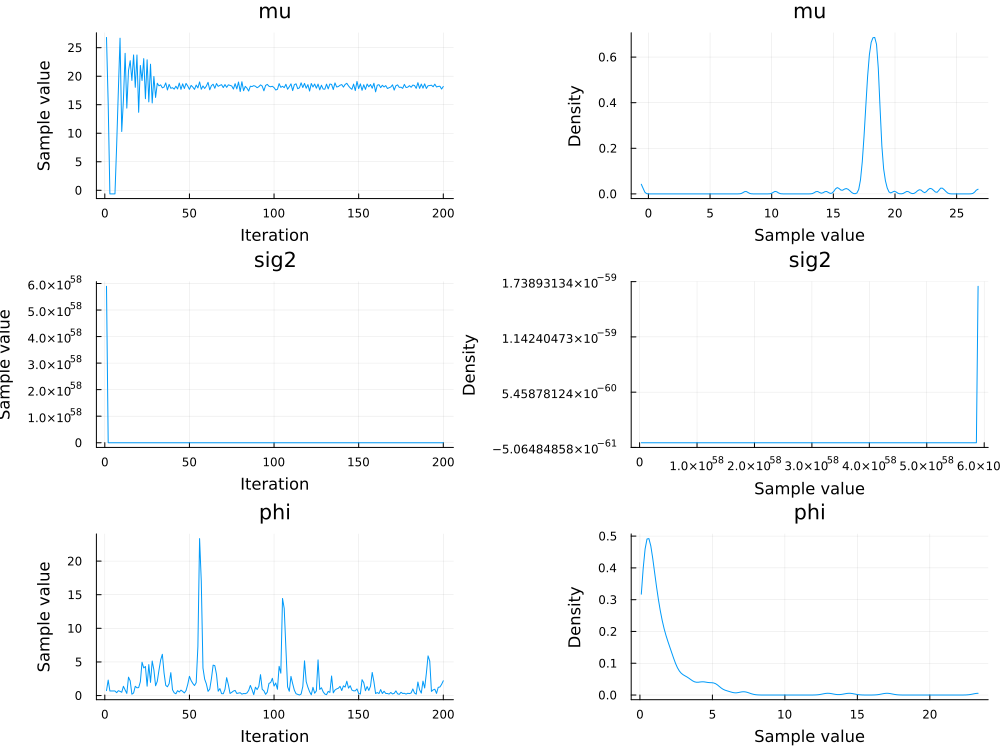

In [491]:
plot(chain)

In [490]:
chain[:log_density]

2-dimensional AxisArray{Float64,2,...} with axes:
    :iter, 1:1:200
    :chain, 1:1
And data, a 200×1 Matrix{Float64}:
 -34481.436861895694
 -17476.882015150593
 -13069.206437977708
 -13069.206437977708
 -13069.206437977708
 -13069.206437977708
  -7721.48434917021
  -6920.52084121626
  -6375.813038997523
  -5690.660582315849
  -5611.802471570366
  -5484.545851497025
  -5292.226795349373
      ⋮
  -1454.4327784585726
  -1455.6456348733886
  -1455.7363000817058
  -1455.4525178658316
  -1454.7744587062882
  -1454.7965612150374
  -1454.435196694686
  -1456.727374700155
  -1455.5782032250545
  -1453.942410868094
  -1454.7025591002216
  -1454.9197727741648

In [494]:
mean(chain[:mu])

17.92405313363294

In [487]:
chain[:phi]

2-dimensional AxisArray{Float64,2,...} with axes:
    :iter, 1:1:200
    :chain, 1:1
And data, a 200×1 Matrix{Float64}:
 0.7368908505156897
 2.2963682778019283
 0.675556733169764
 0.675556733169764
 0.675556733169764
 0.675556733169764
 0.42653344853443315
 0.7232000328806516
 0.6183635648551523
 0.48540169881508155
 1.373300403016959
 0.8301124937879083
 0.31489174163971456
 ⋮
 1.1212283051204306
 3.3230621407198684
 5.902674166610751
 5.137130144692241
 0.6134984068538014
 0.8400952243507491
 0.939281283940782
 0.318821181950565
 1.2209210906694343
 1.2702884914145711
 1.6595523886226398
 2.196048350025013

In [485]:
chain[:sig2]

2-dimensional AxisArray{Float64,2,...} with axes:
    :iter, 1:1:200
    :chain, 1:1
And data, a 200×1 Matrix{Float64}:
  5.893562175912477e58
  0.0009710035986577335
  1.1984736216536931e26
  1.1984736216536931e26
  1.1984736216536931e26
  1.1984736216536931e26
  8.68000210052581e15
  1.2278679691258411e14
  3.6524345750982324e12
  5.897878757635011e11
  2.856280219060919e11
  7.078641569441437e10
  6.798375131369034e10
  ⋮
 58.81407499055566
 71.10555810564469
 65.27402086688159
 59.19330821524324
 66.93277460134996
 69.70832755225719
 63.096938355927236
 74.12210624423545
 72.02283342834082
 63.30451966194873
 63.2568796279468
 68.68943744259964

In [495]:
size(x1)

(1, 364)

In [496]:
mean(chain[:sig2])

2.9467810879562382e56

In [499]:
mean(chain[:mu])* ones(1)

1-element Vector{Float64}:
 17.92405313363294

1×1 Diagonal{Bool, Vector{Bool}}:
 1

In [502]:
mean(chain[:sig2]) * LinearAlgebra.I(1)

1×1 Diagonal{Float64, Vector{Float64}}:
 2.9467810879562382e56

In [506]:
mean(chain[:mu])* ones(1)

1-element Vector{Float64}:
 17.92405313363294

In [507]:
D = pairwise(Distances.Euclidean(), x1, dims=1)
    

1×1 Matrix{Float64}:
 0.0

In [510]:
K = exp_cov_fn(D, chain[:sig2])

1×200 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [511]:
group(chain, :mu).value.data[:, :, 1]

200×1 Matrix{Float64}:
 26.793434269779677
 15.199664201511423
 -0.6304092225182952
 -0.6304092225182952
 -0.6304092225182952
 -0.6304092225182952
  7.8828981605088195
 17.47259171320867
 26.66348756523049
 10.306368364457313
 15.862875274147486
 24.012946888647743
 14.401557363302762
  ⋮
 18.657826031741987
 17.848380273603663
 18.32623984528483
 18.36224467700151
 18.425827733102835
 18.145753833561077
 18.60228278830504
 18.11432167063374
 18.207169143128244
 18.246810704014596
 17.74743380883986
 18.196875291793475

In [512]:
group(chain, :sig2).value.data[:, :, 1]

200×1 Matrix{Float64}:
  5.893562175912477e58
  0.0009710035986577335
  1.1984736216536931e26
  1.1984736216536931e26
  1.1984736216536931e26
  1.1984736216536931e26
  8.68000210052581e15
  1.2278679691258411e14
  3.6524345750982324e12
  5.897878757635011e11
  2.856280219060919e11
  7.078641569441437e10
  6.798375131369034e10
  ⋮
 58.81407499055566
 71.10555810564469
 65.27402086688159
 59.19330821524324
 66.93277460134996
 69.70832755225719
 63.096938355927236
 74.12210624423545
 72.02283342834082
 63.30451966194873
 63.2568796279468
 68.68943744259964

In [514]:
group(chain, :phi).value.data[:, :, 1]

200×1 Matrix{Float64}:
 0.7368908505156897
 2.2963682778019283
 0.675556733169764
 0.675556733169764
 0.675556733169764
 0.675556733169764
 0.42653344853443315
 0.7232000328806516
 0.6183635648551523
 0.48540169881508155
 1.373300403016959
 0.8301124937879083
 0.31489174163971456
 ⋮
 1.1212283051204306
 3.3230621407198684
 5.902674166610751
 5.137130144692241
 0.6134984068538014
 0.8400952243507491
 0.939281283940782
 0.318821181950565
 1.2209210906694343
 1.2702884914145711
 1.6595523886226398
 2.196048350025013

In [505]:
Normal(mean(chain[:mu])* ones(1), mean(chain[:sig2]) * 1)

LoadError: MethodError: no method matching Normal(::Vector{Float64}, ::Float64)
[0mClosest candidates are:
[0m  Normal([91m::T[39m, ::T; check_args) where T<:Real at ~/.julia/packages/Distributions/gggmX/src/univariate/continuous/normal.jl:36
[0m  Normal([91m::Real[39m, ::Real; check_args) at ~/.julia/packages/Distributions/gggmX/src/univariate/continuous/normal.jl:42

In [484]:
chain[:mu]

2-dimensional AxisArray{Float64,2,...} with axes:
    :iter, 1:1:200
    :chain, 1:1
And data, a 200×1 Matrix{Float64}:
 26.793434269779677
 15.199664201511423
 -0.6304092225182952
 -0.6304092225182952
 -0.6304092225182952
 -0.6304092225182952
  7.8828981605088195
 17.47259171320867
 26.66348756523049
 10.306368364457313
 15.862875274147486
 24.012946888647743
 14.401557363302762
  ⋮
 18.657826031741987
 17.848380273603663
 18.32623984528483
 18.36224467700151
 18.425827733102835
 18.145753833561077
 18.60228278830504
 18.11432167063374
 18.207169143128244
 18.246810704014596
 17.74743380883986
 18.196875291793475

In [482]:
Variational.meanfield(m)

MultivariateTransformed{DistributionsAD.TuringDiagMvNormal{Vector{Float64}, Vector{Float64}}, Stacked{Tuple{Identity{0}, Bijectors.Exp{0}, Bijectors.Exp{0}}, Vector{UnitRange{Int64}}}}(
dist: DistributionsAD.TuringDiagMvNormal{Vector{Float64}, Vector{Float64}}(m=[0.5687617320850814, -0.9505937563565442, -1.2610155788358448], σ=[0.5029164181076047, 0.8141308413234468, 0.4010884766921752])
transform: Stacked{Tuple{Identity{0}, Bijectors.Exp{0}, Bijectors.Exp{0}}, Vector{UnitRange{Int64}}}((Identity{0}(), Bijectors.Exp{0}(), Bijectors.Exp{0}()), UnitRange{Int64}[1:1, 2:2, 3:3])
)
